## A/B Testing 

### Which KPI should be used in A/B testing?
* **conversion rate:** percentage of users who subscribe after the free trial
* ####  Question: in which interval I should consider conversion rate?
* conversion immediately after lapse
* one week after
* one month after

### Choosing KPI based on :
* #### stability over time and generalizabe for different demographies
* #### the one with high correlation with important factors like retention or spending 

## About Dataset

### Data description
#### The data I have is from 90,189 players that installed the game while the AB-test was running. The variables are:

* **userid:** a unique number that identifies each player.
* **version:** whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
* **sum_gamerounds:** the number of game rounds played by the player during the first 14 days after install.
* **retention_1:** did the player come back and play 1 day after installing?
* **retention_7:** did the player come back and play 7 days after installing?


## When a player installed the game, the player was randomly assigned to either gate at level of 30 or gate at level of 40, control or variant respectively . The focus of this analysis will be on how the gate placement affects player retention.

## 1) Review the dateset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
game = pd.read_csv('cookie_cats.csv')
print(game.shape)
game.head()

(90189, 5)


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
game.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


## 2) The AB-test data
The dataset include data about 90,189 players who installed the game while the A/B testing was running.

 #### As a sanity check, let's see if there are roughly the same number of players in each AB group.

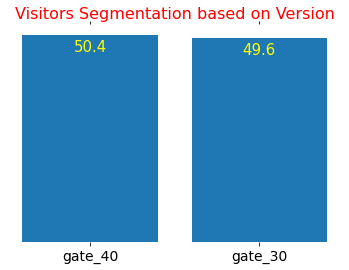

In [5]:
visitors_seg = round(100*(game.version.value_counts(normalize= True, dropna= False)), 1)
bars= plt.bar(x= visitors_seg.index, height= visitors_seg)
for bar in bars:
    plt.gca().text( bar.get_x() + bar.get_width()/2 , bar.get_height() -4,
                   bar.get_height().round(3), ha='center', color='yellow', fontsize=15)

for spine in plt.gca().spines.values():
    spine.set_visible (False)
    
plt.tick_params (top='off', bottom='off', left=False , right=False, labelleft=False, labelbottom='on')

plt.xticks(fontsize=14)    
plt.title('Visitors Segmentation based on Version',fontsize=16, c='red')    
plt.show()

#### I have almost balanced classes.

## 3) The distribution of the game rounds


In [6]:
game.sum_gamerounds.describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

<Figure size 1296x432 with 0 Axes>

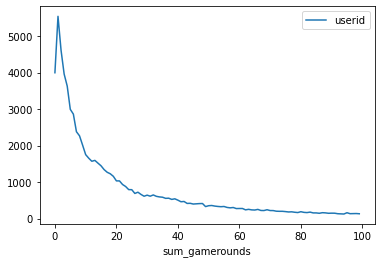

In [8]:
sum_game= pd.DataFrame(game.groupby('sum_gamerounds')['userid'].count().head(100))

plt.figure(figsize=(18,6))
sum_game.plot()
plt.show()

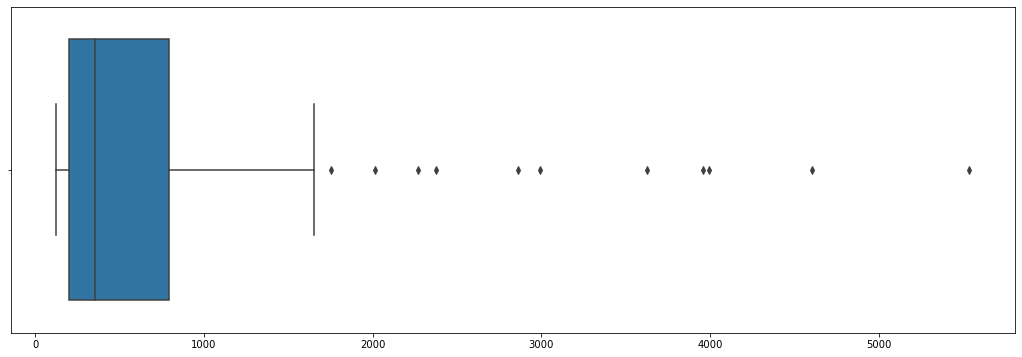

In [9]:
plt.figure(figsize=(18,6))
sns.boxplot(sum_game)
plt.show()

### It seems that there are outliers.
### Under a classical definition of an outlier as a data point out lie the 1.5* IQR from the upper or lower quartile.

IQR = 75th quantile — 25th quantile

Let's remove the outliers

In [11]:
IRQ = game.sum_gamerounds.quantile(0.75) - game.sum_gamerounds.quantile(0.25)

df = game[(game.sum_gamerounds <= game.sum_gamerounds.quantile(0.75) + 1.5* IRQ) &
         (game.sum_gamerounds >= game.sum_gamerounds.quantile(0.25) - 1.5* IRQ)]

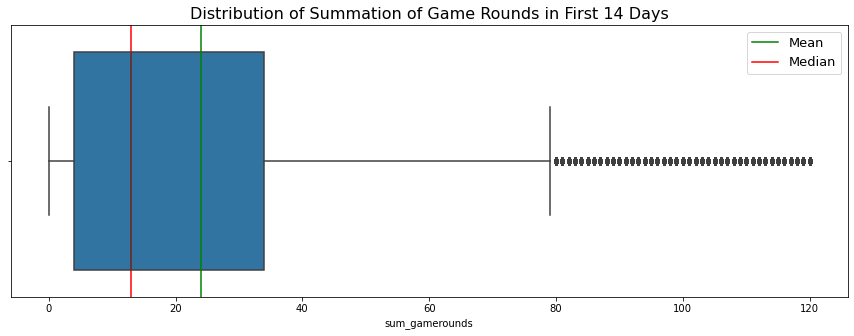

In [12]:
plt.figure(figsize=(15,5))
sns.boxplot(df.sum_gamerounds)
plt.axvline(df.sum_gamerounds.mean(), color='green', label='Mean')
plt.axvline(df.sum_gamerounds.median(), color='red', label= 'Median')
plt.title('Distribution of Summation of Game Rounds in First 14 Days', fontsize=16)
plt.legend(fontsize=13)
plt.show()

#### Distribution of sum of game rounds is very skewed to right.

In [13]:
from scipy import stats as st
st.percentileofscore (df.sum_gamerounds, 120)

99.93875918612208

#### 99.94% of visitors played totally less than or equal to 120 times.
* some players install the game and never play so their game rounds is equal to zero,
* some playes only play a couple time, but there are some players who get really hooked.

## 3)  One-day retention
The desired situation is that players like the game and get hooked.
**One of good metric in game industry is 1-day retention which quantify how much the game is fun and players get hooked.**
**1-day retention** is the percentage of players who come back and play one day after game installation. 


**The higher one-day retention, the easier to retain players and building a larger customer base.**


In [14]:
control = df[df.version == 'gate_30']
variant = df[df.version == 'gate_40']

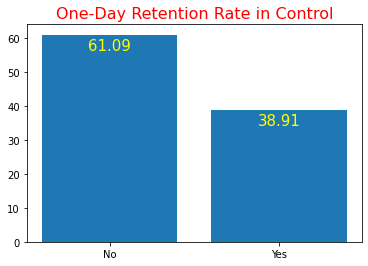

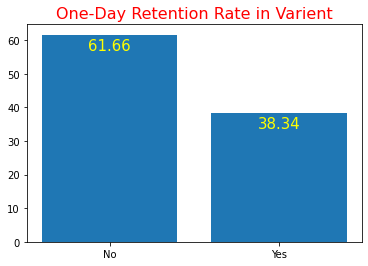

In [15]:
control_retention1 = round(100 * control.retention_1.value_counts(normalize= True) ,2)
bars= plt.bar(x= control_retention1.index, height= control_retention1)
plt.xticks(list(control_retention1.index), ['No', 'Yes']) 
plt.title('One-Day Retention Rate in Control',fontsize=16, c='red')  
for bar in bars:
    plt.gca().text( bar.get_x() + bar.get_width()/2 , bar.get_height() -4.5,
                   bar.get_height().round(3), ha='center', color='yellow', fontsize=15)
    
plt.show()   

variant_retention1 = round(100 * variant.retention_1.value_counts(normalize= True) ,2)
bars2= plt.bar(x= variant_retention1.index, height= variant_retention1)
plt.xticks(list(variant_retention1.index) , ['No', 'Yes']) 
plt.title('One-Day Retention Rate in Varient',fontsize=16, c='red')  
for bar in bars2:
    plt.gca().text( bar.get_x() + bar.get_width()/2 , bar.get_height() -4.5,
                   bar.get_height().round(3), ha='center', color='yellow', fontsize=15)
    
plt.show() 
   

#### There is a slight decrease (0.57%) in one-day retention day, when the gate was moved to level 40 (Variant), in comparison with when the gate was at level 30 (control).

#### Even the small changes in one-day retention, will result in a large impact in the customer base.

### 3.1) How much is the uncertainty for the one-day retention?
In order to calculate the certainty of the retention rate, I will use **bootstrapping**. For this purpose, I will take sample with replacement from the dataset, in each sampling the players are grouped by the version then mean of one-day retention will be calculated.

The variability of mean of one-day retention is an indication of uncertainty.

In [16]:
#create a list of boostrapped means for each A/B groups
n_sampling = 10000

#f: sum of percentage of two groups become 1
boot_retention1 = pd.DataFrame([100 *(df.sample(frac=1, replace=True).
                                groupby('version')['retention_1'].mean()) for i in np.arange(n_sampling)])

boot_retention1.head()

version,gate_30,gate_40
retention_1,39.474283,38.348950
retention_1,38.710165,38.395955
retention_1,39.151027,38.807451
retention_1,39.308714,38.358172
retention_1,38.829065,38.277952


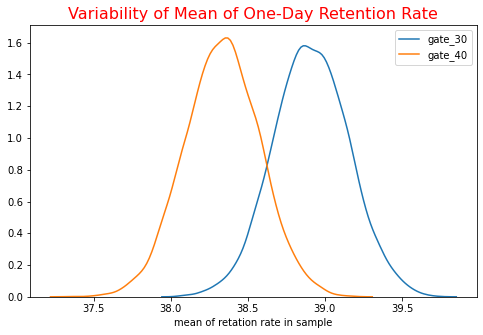

In [17]:
plt.figure(figsize=(8,5))
sns.kdeplot(boot_retention1.gate_30)
sns.kdeplot(boot_retention1.gate_40)
plt.xlabel('mean of retation rate in sample')
plt.title('Variability of Mean of One-Day Retention Rate', color= 'red', fontsize= 16)
plt.show()

### 3.2) Zoom at the difference between control and variant

95% CI:  (-0.29003853356284215, 3.2491485335628356)


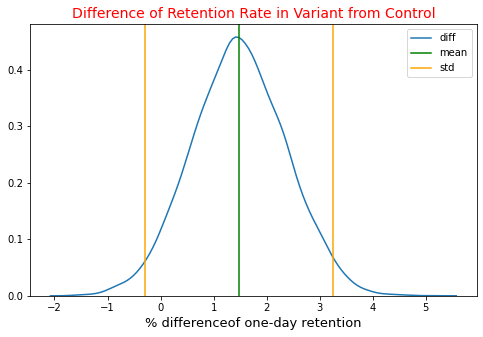

In [18]:
boot_retention1['diff'] = round(100*((boot_retention1['gate_30'] - boot_retention1['gate_40'])/ boot_retention1['gate_30']), 2)

mean = boot_retention1['diff'].mean()
std = boot_retention1['diff'].std(ddof=1)
CI= (mean- 2* std, mean+ 2* std)
print('95% CI: ', CI)


plt.figure(figsize=(8,5))
sns.kdeplot(boot_retention1['diff'])
plt.axvline(boot_retention1['diff'].mean(), color='green', label= 'mean')
plt.axvline(mean- 2* std, color='orange', label= 'std')
plt.axvline(mean+ 2* std, color='orange')
plt.xlabel('% differenceof one-day retention', fontsize= 13)
plt.title('Difference of Retention Rate in Variant from Control',color='red', fontsize=14)
plt.legend()
plt.show()

#### The small difference in retention rate between control and variant in graph is more obvious.
### The confidence interval of (-0.29, 3.24) includes the true value of difference in 95% of times.

### 3.3) Probability of a Difference
**What is the probability of difference being greater than zero in favore of gate at level 30?**

In [19]:
prob_positive_diff = round(sum(boot_retention1['diff']>0) / len(boot_retention1['diff']),2)
print('Probability that control version (gate at level 30) results in higher one-day retention is {}'.format(prob_positive_diff ))

Probability that control version (gate at level 30) results in higher one-day retention is 0.95


### The bootstrap analysis shows that the probability that control version (gate at level 30) results in higher one-day retention is 0.95.

## 4) Seven-day retention by AB-group
It is more probable that many players couldn't reach gate at the level 30 in only one day after the game installation, so it makes sense that many players weren't affected by gate at level 30 in one day.

**With having played for one week, it is more probable that many players reach to the level 40, so let's look at the seven-day retention rate.**

**seven-day retention rate** is the percentage of players who installed the game and showed up that they were playing the game a week later.


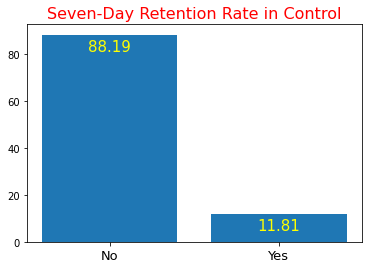

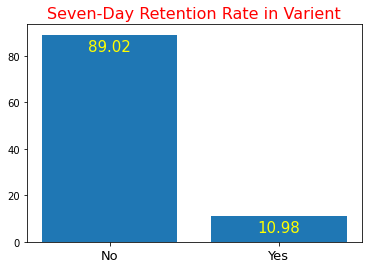

In [20]:
control_retention7 = round(100 * control.retention_7.value_counts(normalize= True) ,2)
bars= plt.bar(x= control_retention7.index, height= control_retention7)
plt.xticks(list(control_retention7.index), ['No', 'Yes'],fontsize=13) 
plt.title('Seven-Day Retention Rate in Control',fontsize=16, c='red')  
for bar in bars:
    plt.gca().text( bar.get_x() + bar.get_width()/2 , bar.get_height() -7,
                   bar.get_height().round(3), ha='center', color='yellow', fontsize=15)
    
plt.show()   

variant_retention7 = round(100 * variant.retention_7.value_counts(normalize= True) ,2)
bars2= plt.bar(x= variant_retention7.index, height= variant_retention7)
plt.xticks(list(variant_retention7.index) , ['No', 'Yes'],fontsize=13) 
plt.title('Seven-Day Retention Rate in Varient',fontsize=16, c='red')  
for bar in bars2:
    plt.gca().text( bar.get_x() + bar.get_width()/2 , bar.get_height() -7,
                   bar.get_height().round(3), ha='center', color='yellow', fontsize=15)
    
plt.show() 

#### There is a slight decrease (0.83%) in seven-day retention day, when the gate was moved to level 40 (Variant), in comparison with when the gate was at level 30 (control).

#### The difference is higher than one-day retention.

#### Even the small changes in seven-day retention  will result in a large impact in the customer base.

## 4.1) How much is the uncertainty for the Seven-day retention rate using bootstrapping method?

In [21]:
#create a list of boostrapped means for each A/B groups
n_sampling = 10000

#f: sum of percentage of two groups become 1
boot_retention7 = pd.DataFrame([100 *(df.sample(frac=1, replace=True).
                                groupby('version')['retention_7'].mean()) for i in np.arange(n_sampling)])

boot_retention7.head()

version,gate_30,gate_40
retention_7,11.946468,10.955746
retention_7,11.917608,10.919996
retention_7,12.181332,11.157598
retention_7,11.834709,10.948221
retention_7,11.744452,11.147851


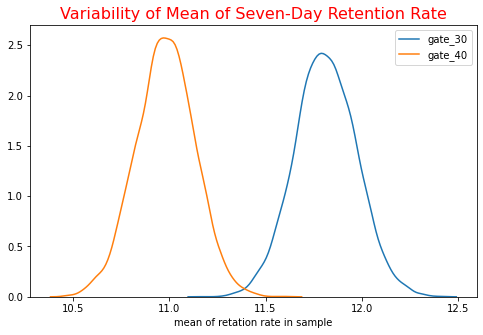

In [22]:
plt.figure(figsize=(8,5))
sns.kdeplot(boot_retention7.gate_30)
sns.kdeplot(boot_retention7.gate_40)
plt.xlabel('mean of retation rate in sample')
plt.title('Variability of Mean of Seven-Day Retention Rate', color= 'red', fontsize= 16)
plt.show()

### 4.2) Zoom at the difference between control and variant

95% CI:  (3.405352276052296, 10.6725337239477)


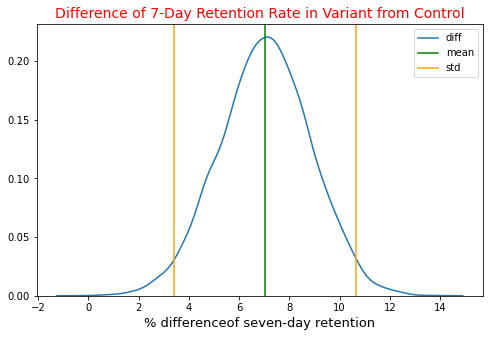

In [23]:
boot_retention7['diff'] = round(100*((boot_retention7['gate_30'] - boot_retention7['gate_40'])/ boot_retention7['gate_30']), 2)

mean = boot_retention7['diff'].mean()
std = boot_retention7['diff'].std(ddof=1)
CI= (mean- 2* std, mean+ 2* std)
print('95% CI: ', CI)


plt.figure(figsize=(8,5))
sns.kdeplot(boot_retention7['diff'])
plt.axvline(boot_retention7['diff'].mean(), color='green', label= 'mean')
plt.axvline(mean- 2* std, color='orange', label= 'std')
plt.axvline(mean+ 2* std, color='orange')
plt.xlabel('% differenceof seven-day retention', fontsize= 13)
plt.title('Difference of 7-Day Retention Rate in Variant from Control',color='red', fontsize=14)
plt.legend()
plt.show()

#### The small difference in 7-day retention rate between control and variant in graph is more obvious.
### The confidence interval of (3.4, 10.67) includes the true value of difference in 95% of times.

### 4.3) Probability of a Difference
**What is the probability of difference being greater than zero in favore of gate at level 30?**

In [24]:
prob_positive_diff = round(100* sum(boot_retention7['diff']>0) / len(boot_retention7['diff']),4)
print('Probability that control version (gate at level 30) results in higher one-day retention is {}%'.format(prob_positive_diff ))

Probability that control version (gate at level 30) results in higher one-day retention is 99.99%


### The bootstrap analysis shows that the probability that control version (gate at level 30) results in higher seven-day retention is 99.99% of times.

## Conclusion
### Recommendation
**With using bootstap method, there is a difference between mean of one-day retention and mean of seven-day retention in favore of control at 5% significance level. So, it is recommended that the company keep the gate at level of 30 and not moving it to level of 40.**

This recommendation not only is supported by data, but also is supported by **Hedonic Adaption Theory**. 
Hedonic adaption is a tendency that people enjoy less and less from a fun activity like entertainment if the activity isn't taken continuously.  Players were forced to take a break when they reach a gate, their fun and enjoyment of the game is prolonged. Moving the game to level of 40 more probably made the player bored and caused players to give up.


### Metrics
In this case, I analyzed the A/B testing results on retention rate since it is the most important factor to enlarge customer base and generate more revenue. 
Of course there are other metrics such as the number of game rounds played or revenue from purchasing game that can be observed by A/B testing. But observing them is worth when the company could retain its playes.
